# Monte Carlo Simulation

In [1]:
import matplotlib.pyplot as plt 
import numpy as np
import sdm

## Define model

In [2]:
# define adjacency matrix
matrix = np.array([
    [0,1,1,0,1,1,0,0],
    [1,0,1,0,1,1,1,0],
    [1,1,0,1,1,0,0,0],
    [0,0,1,0,0,0,1,0],
    [1,1,1,0,0,0,0,0],
    [1,1,0,0,0,0,1,0],
    [0,1,0,1,0,0,0,0],
    [0,0,1,0,0,1,0,0],
])

In [3]:
# define parameters of data generating process
params_filter = {
    "vOmega": np.array([0.1, 0.08]),
    "vA": np.array([0.1, 0.05]),
    "vB": np.array([0.8, 0.6]),
}

params_observation = {
    "vBeta": np.array([1.5]),
    "dSigma2": np.array([2.0])
}

In [4]:
# define time series length
iT = 1000

In [5]:
# infer model size
iN, _ = matrix.shape
iI = len(params_filter["vOmega"])
iK = len(params_observation["vBeta"])

In [7]:
# define configurations for the spatial gas model
model = sdm.SpatialGasModel("mvnorm", "identity", 0.99)

In [8]:
# simulate covariates
mmX = sdm.covariates.simulate(iT, iN, iK)

In [9]:
# add adjacency matrix and build iT x iN x iN weighting matrix
adjacency_matrix = sdm.AdjacencyMatrix()
adjacency_matrix.add(0, iT, matrix)
mmW = adjacency_matrix.build()

## Monte Carlo Simulation

### Simulate and Estimate

In [10]:
# initialize
iB = 5

# instantiate experiment
monte_carlo = sdm.MonteCarlo(params_observation, params_filter, "dynamic_heterogenous")

for b in range(iB):
    # status
    print(f"Iteration: {b+1}", end="\r")
    # simulate model
    model_sim = model.simulate(mmX, mmW, params_filter, params_observation, "autoregressive")
    # estimate the model
    model_fit = model.estimate(model_sim.mY, mmX, mmW, iI, "dynamic_heterogenous")
    # store result
    monte_carlo.add(model_fit.params, model_sim.mRho, model_fit.mRho, model_fit.convergence, model_fit.elapsed_time)

## Result

### Spatial dependence plots

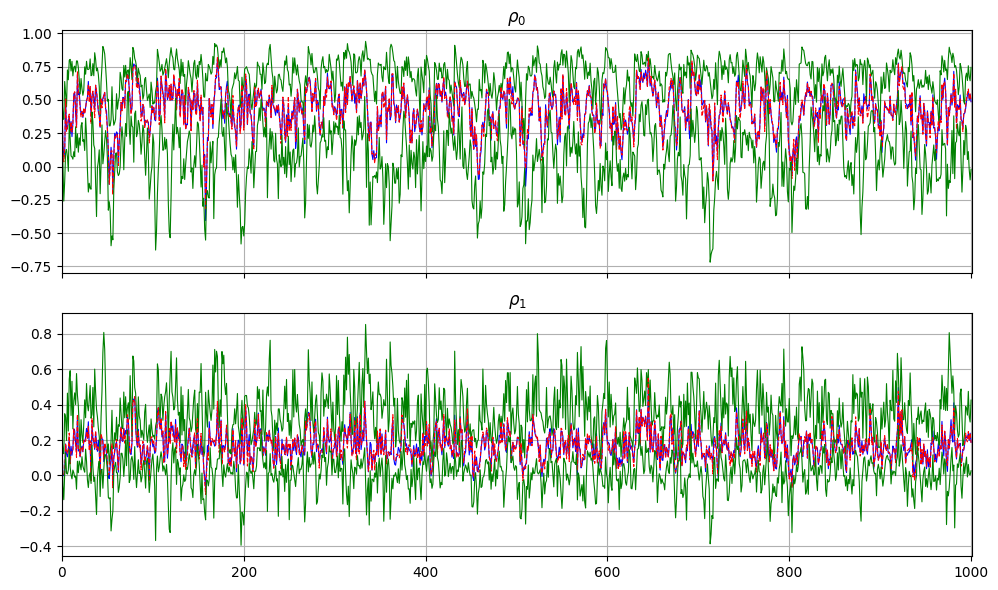

In [11]:
# setting
lb = 0.05
ub = 1-0.05

# compute average of simulated mRho
simulated = np.median(monte_carlo.rho_simulated, axis=0)

# compute quantiles of filtered spatial dependence
estimated_median = np.median(monte_carlo.rho_estimated, axis=0)
estimated_lb = np.quantile(monte_carlo.rho_estimated, lb, axis=0)
estimated_ub = np.quantile(monte_carlo.rho_estimated, ub, axis=0)

# infer model size
iT, iP = simulated.shape
time_periods = np.arange(iT)

# setup plot
fig, axs = plt.subplots(figsize=(10,6), nrows=iP, sharex=True)

# spatial parameter
for i in range(iP):
    axs[i].plot(time_periods, simulated[:,i], color="b", linestyle="solid", linewidth=0.8)
    axs[i].plot(time_periods, estimated_ub[:,i], color="g", linestyle="solid", linewidth=0.8)
    axs[i].plot(time_periods, estimated_median[:,i], color="r", linestyle="dashed", linewidth=0.8)
    axs[i].plot(time_periods, estimated_lb[:,i], color="g", linestyle="solid", linewidth=0.8)

# axis
for i in range(iP):
    axs[i].set_title(r"$\rho_{}$".format(i))
    axs[i].grid(True)
    axs[i].set_xlim(0,iT)

fig.tight_layout()
#plt.show()

### Density plots

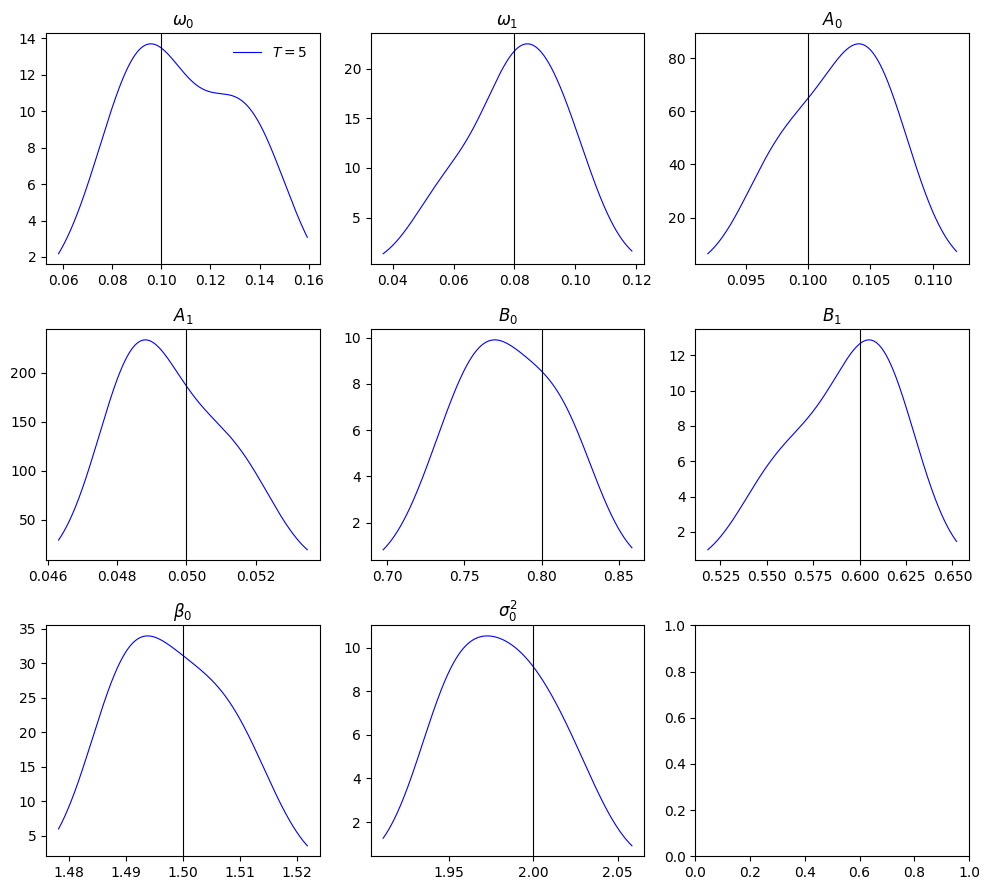

In [12]:
if monte_carlo.nparams % 3 == 0:
    fig, axs = plt.subplots(figsize=(10,9), nrows=int(monte_carlo.nparams / 3), ncols=3)
else:
    fig, axs = plt.subplots(figsize=(10,9), nrows=int(monte_carlo.nparams / 3 + 1), ncols=3)

# get frame
df = monte_carlo.params_est

# plot by parameter
columns = df.columns

for ax, idx in zip(axs.flatten()[:len(df.columns)], df.columns):
    param_label, param_id = idx
    # draw estimates' density and true value
    df[idx].plot(
        ax=ax,
        kind="density",
        color="blue",
        linewidth=0.8,
        label=r"$T = {}$".format(monte_carlo.size)
    )
    ax.axvline(x=monte_carlo.params_dgp[param_label][param_id], color="black", linestyle="solid", linewidth=0.8)
    
    # hide yaxis label
    ax.yaxis.label.set_visible(False)
    
    # set title
    label = {
        "vOmega": "\\omega",
        "vA": "A",
        "vB": "B",
        "vBeta": "\\beta",
        "dSigma2": "\\sigma^2"
    }
    title = r"${}_{}$".format(label[param_label], param_id)
    ax.set_title(title)

# legend
axs[0,0].legend(frameon=False, loc="upper right")

fig.tight_layout()

plt.show()